[*********************100%***********************]  1 of 1 completed


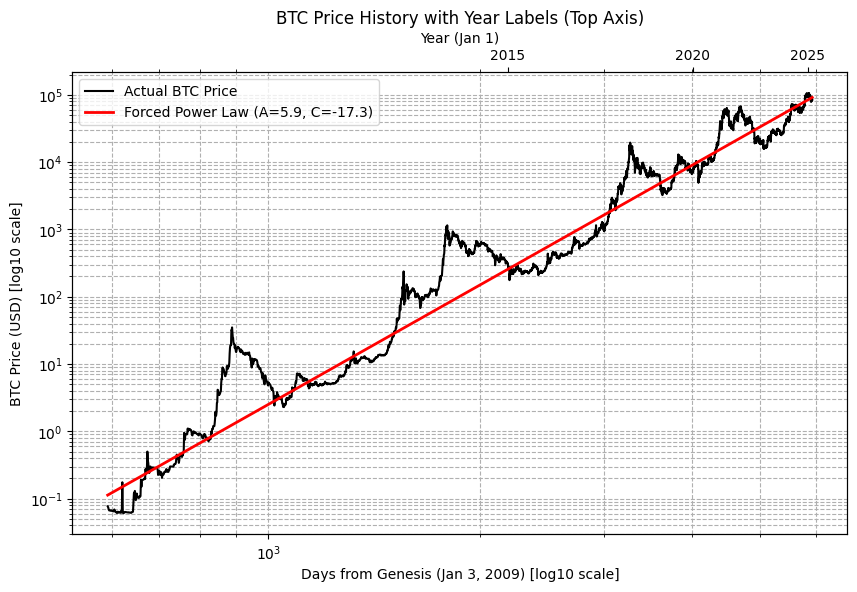

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



# Read the CSV file (assuming it's in the same folder as your script)
df = pd.read_csv('//Users//marcusmccourt//Documents//GitHub Projects//Personal.Projects//bitcoin_dataset.csv')

df = df[['Date', 'btc_market_price']]

# Convert the Date column to datetime, if needed
df['Date'] = pd.to_datetime(df['Date'])


df.columns = df.columns.str.strip()
if 'btc_market_price' in df.columns:
    df.rename(columns={'btc_market_price': 'Price'}, inplace=True)
if 'Date' not in df.columns and 'date' in df.columns:
    df.rename(columns={'date': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Price']]

# --- Download yfinance data ---
ticker = "BTC-USD"
start_date = "2014-12-17"
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date)

# Reset index so Date becomes a column
data.reset_index(inplace=True)

# If data has MultiIndex columns, flatten them:
if isinstance(data.columns, pd.MultiIndex):
    # Option 1: get only the top level of the index:
    data.columns = data.columns.get_level_values(0)
    # Option 2 (alternative): you could use a list comprehension:
    # data.columns = [col[0] for col in data.columns]


# We assume that after flattening, the columns are something like ['Date', 'Close', ...]
# Select only the 'Date' and 'Close' columns and then rename 'Close' to 'Price'
data = data[['Date', 'Close']]
data.rename(columns={'Close': 'Price'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# --- Combine the two DataFrames ---
combined_df = pd.concat([df, data], ignore_index=True)

# Keep only the two columns we want (Date and Price)
combined_df = combined_df[['Date', 'Price']]

# Sort by Date and drop duplicates if any
combined_df.sort_values(by='Date', inplace=True)
combined_df.drop_duplicates(subset='Date', keep='last', inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# Ensure the Date column is datetime and compute days from genesis if not already done:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
genesis_date = datetime(2009, 1, 3)
combined_df['days_from_genesis'] = (combined_df['Date'] - genesis_date).dt.days
combined_df = combined_df[combined_df['days_from_genesis'] > 0].copy()
# Filter to include only dates from August 17, 2010 onward
combined_df = combined_df[combined_df['Date'] >= pd.to_datetime('2010-08-17')].copy()

# Create the primary plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual BTC Price as a continuous line
ax.plot(combined_df['days_from_genesis'], combined_df['Price'],
        label="Actual BTC Price", color='black', linewidth=1.5)

# Plot the forced power-law model (if desired)
A = 5.9
C = -17.3
ax.plot(combined_df['days_from_genesis'],
        (10 ** C) * (combined_df['days_from_genesis'] ** A),
        label=f"Forced Power Law (A={A}, C={C})", color='red', linewidth=2)

# Set the primary x-axis to a base-10 logarithmic scale
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlabel("Days from Genesis (Jan 3, 2009) [log10 scale]")
ax.set_ylabel("BTC Price (USD) [log10 scale]")
ax.set_title("BTC Price History with Year Labels (Top Axis)")
ax.legend()
ax.grid(True, which="both", ls="--")

# --- Create a Secondary X-Axis for Year Labels ---
ax2 = ax.twiny()  # Create a twin axis sharing the same y-axis

# Get current x-axis limits (in days since genesis)
xlim = ax.get_xlim()
ax2.set_xscale('log', base=10)
ax2.set_xlim(xlim)

# Define the years to display: every 5th year from 2010 to 2025.
years = list(range(2010, 2026, 5))  # This yields [2010, 2015, 2020, 2025]

# Compute tick positions for January 1 of each year relative to the genesis date
tick_positions = []
tick_labels = []
for y in years:
    tick_date = datetime(y, 1, 1)
    pos = (tick_date - genesis_date).days
    # Only include ticks that fall within the current x-axis limits
    if pos >= xlim[0] and pos <= xlim[1]:
        tick_positions.append(pos)
        tick_labels.append(str(y))

ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel("Year (Jan 1)")

plt.show()